In [28]:
# Imports
import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import Point
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import pearsonr



In [2]:
# Load the dataset
emdat_data = pd.read_csv('emdat_data_map.csv')

In [3]:
# Inspect data
emdat_data.head(10)

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale,Latitude,Longitude
0,2001,9,24,2001,10,2,Baja California Sur,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph,25.581801,-111.570616
1,2002,9,20,2002,9,20,Campeche,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,19.000000,-90.500000
2,2002,9,20,2002,9,20,Quintana Roo,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,19.666667,-88.500000
3,2002,9,20,2002,9,20,Yucatan,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,20.684596,-88.875567
4,2002,9,26,2002,9,27,Louisiana,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph,30.870388,-92.007126
5,2002,9,26,2002,9,27,Mississippi,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph,32.971528,-89.734850
6,2002,9,26,2002,9,27,Alabama,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph,33.258882,-86.829534
7,2002,9,26,2002,9,27,Tennessee,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph,35.773008,-86.282008
8,2003,9,18,2003,9,22,North Carolina,16.0,225000.0,225000.0,1685000.0,3370000.0,170.0,Kph,35.672964,-79.039292
9,2003,9,18,2003,9,22,Maryland,16.0,225000.0,225000.0,1685000.0,3370000.0,170.0,Kph,39.516240,-76.938207


In [4]:
# Create a function that will use geolookup and opencage to pull states from stored lat and lon data
def reverse_geocode_opencage(lat, lon, api_key):
    url = f"https://api.opencagedata.com/geocode/v1/json?q={lat}+{lon}&key={api_key}"
    response = requests.get(url)
    result = response.json()
    if result['results']:
        state = result['results'][0]['components'].get('state', 'Unknown')
        return state
    return 'Unknown'

# Define the API key
api_key = '24e16a1fd20b46379fbb15b0cf0c3641'

# Function to get state from a row of the DataFrame
def get_state_from_row(row):
    return reverse_geocode_opencage(row['Latitude'], row['Longitude'], api_key)

# Applying function to each row and create a new column 'State'
emdat_data['State'] = emdat_data.apply(get_state_from_row, axis=1)

emdat_data.head()

,Start Year,Start Month,Start Day,End Year,End Month,End Day,Location,Total Deaths,No. Affected,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude,Magnitude Scale,Latitude,Longitude,State
0,2001,9,24,2001,10,2,Baja California Sur,3.0,3000.0,3800.0,150000.0,400000.0,120.0,Kph,25.581801,-111.570616,Baja California Sur
1,2002,9,20,2002,9,20,Campeche,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,19.000000,-90.500000,Campeche
2,2002,9,20,2002,9,20,Quintana Roo,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,19.666667,-88.500000,Quintana Roo
3,2002,9,20,2002,9,20,Yucatan,13.0,500000.0,500030.0,280000.0,640000.0,180.0,Kph,20.684596,-88.875567,Yucatán
4,2002,9,26,2002,9,27,Louisiana,1.0,13200.0,13200.0,200000.0,300000.0,105.0,Kph,30.870388,-92.007126,Louisiana


In [5]:
# Create csv with added state column for reference if needed
emdat_data.to_csv('emdat_with_states.csv', index=False)

In [43]:
# Create GeoDataFrame to use in mapping
geometry = [Point(xy) for xy in zip(emdat_data['Longitude'], emdat_data['Latitude'])]
geo_df = gpd.GeoDataFrame(emdat_data, geometry=geometry)

# Save to GeoJSON
geo_df.to_file('hurricane_data.geojson', driver='GeoJSON')

In [7]:
# Create dataframe that groups data by year for totals by year
yearly_impact = emdat_data.groupby(['Start Year']).agg({
    'Total Deaths': 'sum',
    'Total Affected': 'sum',
    'Insured Damage (\'000 US$)': 'sum',
    'Total Damage (\'000 US$)': 'sum',
    'Magnitude': 'max'
}).reset_index()

In [8]:
# Rename for clarity
yearly_cleaned = yearly_impact.rename(columns={'Start Year': 'Year'})
yearly_cleaned.head()

,Year,Total Deaths,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$),Magnitude
0,2001,3.0,3800.0,1.500000e+05,4.000000e+05,120.0
1,2002,43.0,1552890.0,1.640000e+06,3.120000e+06,180.0
2,2003,128.0,1800000.0,1.348000e+07,2.696000e+07,170.0
3,2004,200.0,600000.0,1.520000e+08,3.200000e+08,230.0
4,2005,33036.0,9990000.0,1.144950e+09,2.340900e+09,280.0


In [9]:
# Create dataframe that groups by state to see state specific totals
state_impact = emdat_data.groupby('State').agg({
    'Total Deaths': 'sum',
    'Total Affected': 'sum',
    'Insured Damage (\'000 US$)': 'sum',
    'Total Damage (\'000 US$)': 'sum'
}).reset_index()

state_impact.head()

,State,Total Deaths,Total Affected,Insured Damage ('000 US$),Total Damage ('000 US$)
0,Alabama,9328.0,3130824.0,348360000.0,753050000.0
1,Arkansas,115.0,206500.0,25000000.0,43000000.0
2,Auvergne-Rhône-Alpes,88.0,582024.0,30000000.0,95000000.0
3,Baja California Sur,9.0,78935.0,1350000.0,2900000.0
4,California,98.0,612024.0,37600000.0,111000000.0


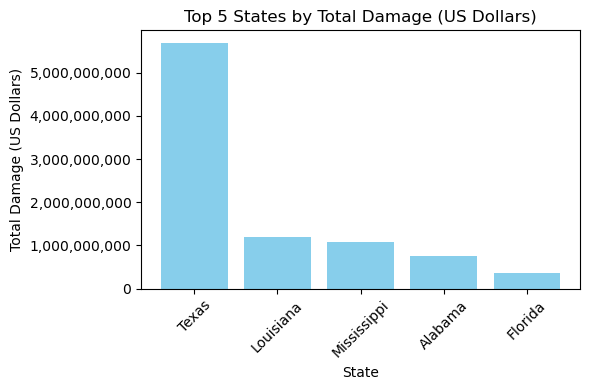

In [93]:
# Sort to get a list of top total deaths by state
top_total_damage = state_impact.sort_values(by='Total Damage (\'000 US$)', ascending=False)

# Get Top 5 for plotting
top_5_total_damage = top_total_damage.head(5)

# Plot with bar chart
plt.figure(figsize=(6, 4))
plt.bar(top_5_total_damage['State'], top_5_total_damage['Total Damage (\'000 US$)'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Total Damage (US Dollars)')
plt.title('Top 5 States by Total Damage (US Dollars)')
plt.xticks(rotation=45)

# Format data to graph without scientific notation
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()




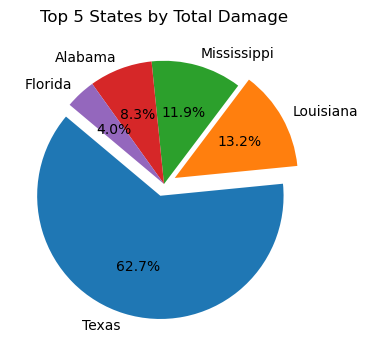

In [13]:
# Plot pie graph for better visualization of proportion
plt.figure(figsize=(4, 4))
explode = [0.1, 0.1, 0, 0, 0]
plt.pie(
    top_5_total_damage['Total Damage (\'000 US$)'],
    labels=top_5_total_damage['State'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.get_cmap('tab10').colors,
    explode=explode
)
plt.title('Top 5 States by Total Damage')
plt.show()

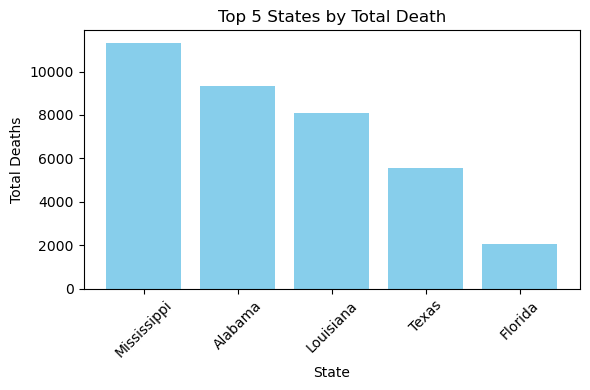

In [14]:
# Sort to get a list of top total deaths by state
top_total_deaths = state_impact.sort_values(by='Total Deaths', ascending=False)

# Seperate top 5 for plotting from the whole data set
top_5_total_deaths = top_total_deaths.head(5)

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(top_5_total_deaths['State'], top_5_total_deaths['Total Deaths'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Total Deaths')
plt.title('Top 5 States by Total Death')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

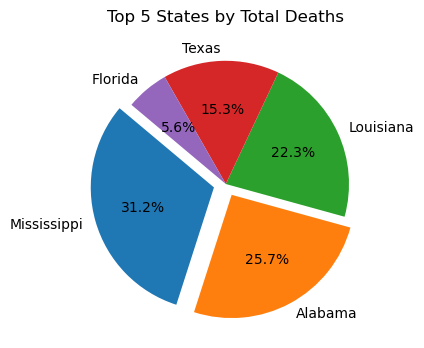

In [90]:
# Plot data in pie chart to better visualize proportion 
plt.figure(figsize=(4, 4))
explode = [0.1, 0.1, 0, 0, 0]
plt.pie(
    top_5_total_deaths['Total Deaths'],
    labels=top_5_total_deaths['State'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.get_cmap('tab10').colors,
    explode=explode
)
plt.title('Top 5 States by Total Deaths')
plt.show()

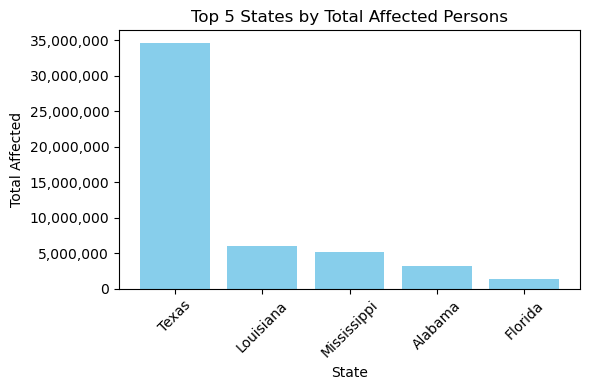

In [23]:
# Sort to get a list of top total affected by state
top_total_affected = state_impact.sort_values(by='Total Affected', ascending=False)

# Seperate top 5 for plotting from the whole data set
top_5_total_affected = top_total_affected.head(5)

# Plotting
plt.figure(figsize=(6, 4))
plt.bar(top_5_total_affected['State'], top_5_total_affected['Total Affected'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Total Affected')
plt.title('Top 5 States by Total Affected Persons')
plt.xticks(rotation=45)

# Format data to graph without scientific notation
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.show()

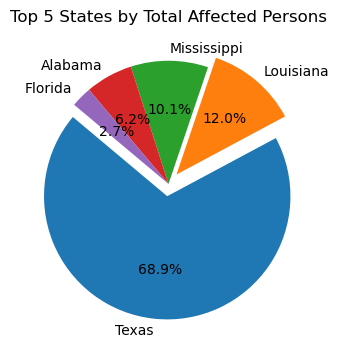

In [93]:
#Plot data in pie chart to better visualize proportion 
plt.figure(figsize=(4, 4))
explode = [0.1, 0.1, 0, 0, 0]
plt.pie(
    top_5_total_affected['Total Affected'],
    labels=top_5_total_affected['State'],
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.get_cmap('tab10').colors,
    explode=explode
)
plt.title('Top 5 States by Total Affected Persons')
plt.show()

In [58]:
# Visualize correlations in a single table across all combinations using a matrix
correlation_matrix = emdat_data[['Magnitude', 'Insured Damage (\'000 US$)', 'Total Damage (\'000 US$)', 'Total Deaths', 'Total Affected']].corr()
correlation_matrix


,Magnitude,Insured Damage ('000 US$),Total Damage ('000 US$),Total Deaths,Total Affected
Magnitude,1.000000,0.567450,0.482778,0.438306,0.361203
Insured Damage ('000 US$),0.567450,1.000000,0.942744,0.736946,0.679521
Total Damage ('000 US$),0.482778,0.942744,1.000000,0.531273,0.842896
Total Deaths,0.438306,0.736946,0.531273,1.000000,0.275169
Total Affected,0.361203,0.679521,0.842896,0.275169,1.000000


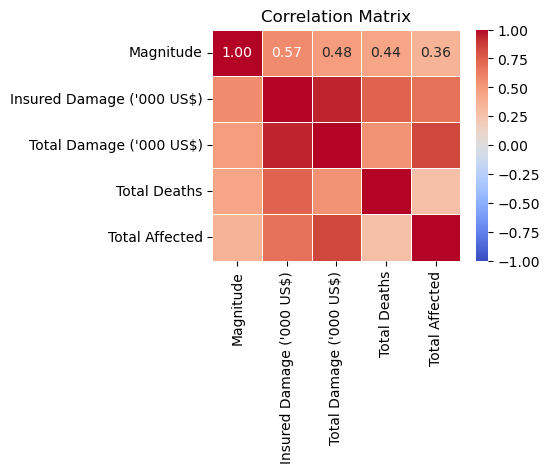

In [59]:
#Plot the correlation matrix
plt.figure(figsize=(4, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

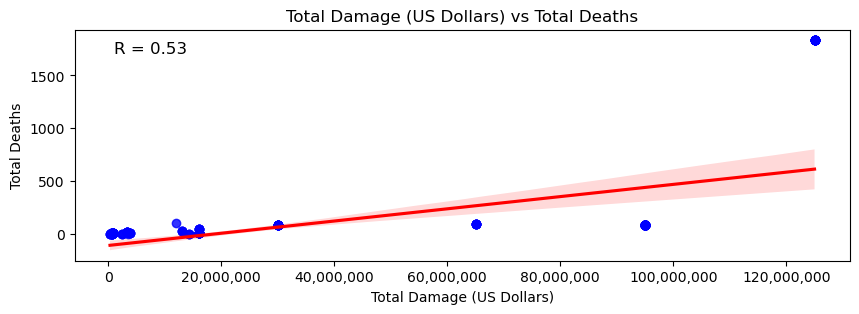

In [92]:
# Visualze possible correlation between damage and deaths

# Generate an R value
corr_coefficient, _ = pearsonr(emdat_data['Total Damage (\'000 US$)'], emdat_data['Total Deaths'])

# Plot data and plot R value - format X axis, scale to remove the scientific notation on graph
plt.figure(figsize=(10, 3))
sns.regplot(data=emdat_data, x='Total Damage (\'000 US$)', y='Total Deaths', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.text(
    0.05, 0.95, f'R = {corr_coefficient:.2f}', 
    transform=plt.gca().transAxes, 
    fontsize=12, 
    verticalalignment='top'
)
plt.title('Total Damage (US Dollars) vs Total Deaths')
plt.xlabel('Total Damage (US Dollars)')
plt.ylabel('Total Deaths')
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.show()

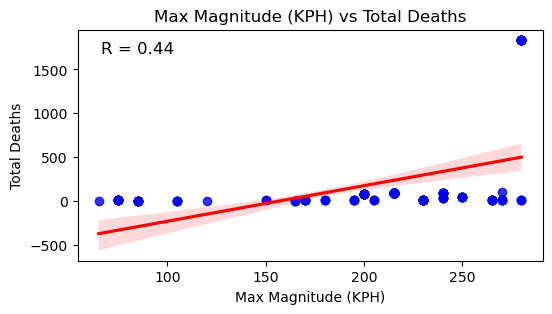

In [90]:
# Visualze possible correlation between magnitude and total deaths

# Generate an R value
corr_coefficient, _ = pearsonr(emdat_data['Magnitude'], emdat_data['Total Deaths'])

# Plot data and plot R value
plt.figure(figsize=(6, 3))
sns.regplot(data=emdat_data, x='Magnitude', y='Total Deaths', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.text(
    0.05, 0.95, f'R = {corr_coefficient:.2f}', 
    transform=plt.gca().transAxes, 
    fontsize=12, 
    verticalalignment='top'
)
plt.title('Max Magnitude (KPH) vs Total Deaths')
plt.xlabel('Max Magnitude (KPH)')
plt.ylabel('Total Deaths')
plt.show()

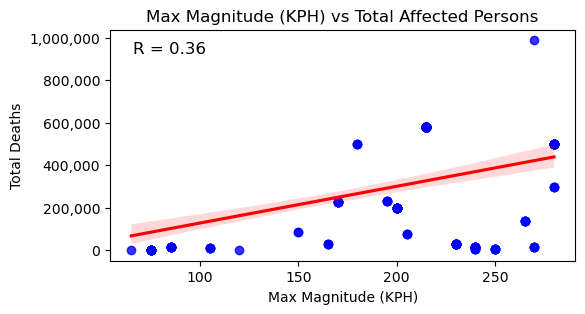

In [88]:
# Visualze possible correlation between magnitude and total affected

# Generate an R value
corr_coefficient, _ = pearsonr(emdat_data['Magnitude'], emdat_data['Total Affected'])

# Plot data and plot R value
plt.figure(figsize=(6, 3))
sns.regplot(data=emdat_data, x='Magnitude', y='Total Affected', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.text(
    0.05, 0.95, f'R = {corr_coefficient:.2f}', 
    transform=plt.gca().transAxes, 
    fontsize=12, 
    verticalalignment='top'
)
plt.title('Max Magnitude (KPH) vs Total Affected Persons')
plt.xlabel('Max Magnitude (KPH)')
plt.ylabel('Total Deaths')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.show()

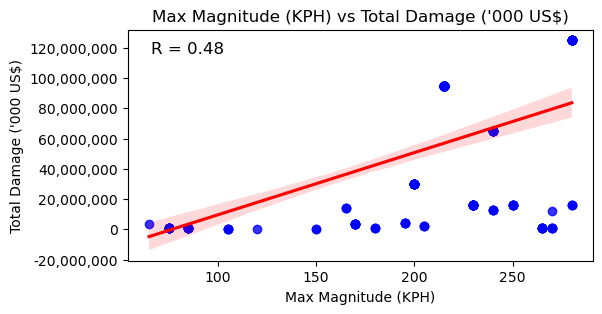

In [89]:
# Visualze possible correlation between magnitude and total damage

# Generate an R value
corr_coefficient, _ = pearsonr(emdat_data['Magnitude'], emdat_data['Total Damage (\'000 US$)'])

# Plot data and plot R value
plt.figure(figsize=(6, 3))
sns.regplot(data=emdat_data, x='Magnitude', y='Total Damage (\'000 US$)', scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.text(
    0.05, 0.95, f'R = {corr_coefficient:.2f}', 
    transform=plt.gca().transAxes, 
    fontsize=12, 
    verticalalignment='top'
)
plt.title('Max Magnitude (KPH) vs Total Damage (\'000 US$)')
plt.xlabel('Max Magnitude (KPH)')
plt.ylabel('Total Damage (\'000 US$)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.show()

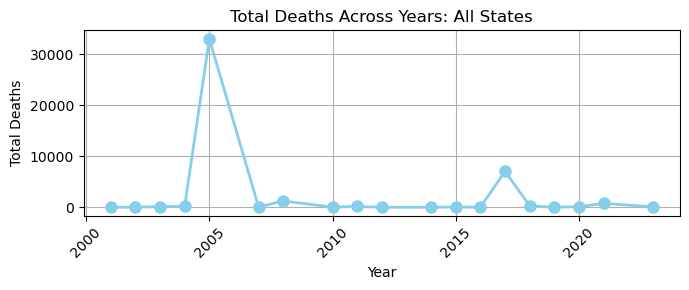

In [77]:
# Plot for total deaths across years
plt.figure(figsize=(7, 3))
plt.plot(yearly_cleaned['Year'], yearly_cleaned['Total Deaths'], marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.title('Total Deaths Across Years: All States')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

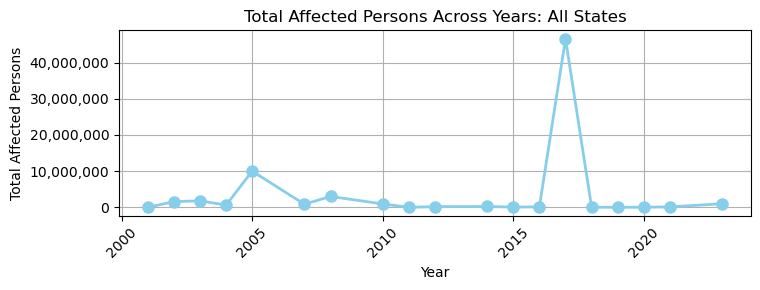

In [78]:
# Plot for total affected persons across years
plt.figure(figsize=(7, 3))
plt.plot(yearly_cleaned['Year'], yearly_cleaned['Total Affected'], marker='o', color='skyblue', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Year')
plt.ylabel('Total Affected Persons')
plt.title('Total Affected Persons Across Years: All States')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
plt.show()

In [67]:
# Group by original Emdat dataframe by 'State' and 'Start Year', summing 'Total Deaths' to begin creating a time series
state_deaths_by_year = emdat_data.groupby(['State', 'Start Year'])['Total Deaths'].sum().reset_index()

# Create pivot table
pivot_state_deaths_by_year = state_deaths_by_year.pivot(index='State', columns='Start Year', values='Total Deaths').fillna(0)

# Filter by states noted to be top 5 in total deaths
top_5_states_total_deaths_timeseries = pivot_state_deaths_by_year.loc[['Mississippi', 'Alabama', 'Louisiana', 'Texas', 'Florida']]

top_5_states_total_deaths_timeseries

Start Year,2001,2002,2003,2004,2005,2007,2008,2010,2011,2012,2014,2015,2016,2017,2018,2019,2020,2021,2023
State,,,,,,,,,,,,,,,,,,,
Mississippi,0.0,1.0,0.0,10.0,11008.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,264.0,0.0,0.0,33.0,0.0,0.0
Alabama,0.0,1.0,0.0,10.0,9165.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,88.0,49.0,0.0,0.0,0.0,0.0
Louisiana,0.0,1.0,0.0,0.0,7342.0,0.0,82.0,0.0,15.0,0.0,0.0,0.0,0.0,528.0,0.0,0.0,33.0,96.0,0.0
Texas,0.0,0.0,0.0,60.0,10.0,0.0,410.0,0.0,15.0,0.0,0.0,0.0,0.0,5016.0,0.0,5.0,33.0,0.0,0.0
Florida,0.0,0.0,0.0,60.0,1841.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,88.0,49.0,0.0,0.0,0.0,0.0


<Figure size 800x600 with 0 Axes>

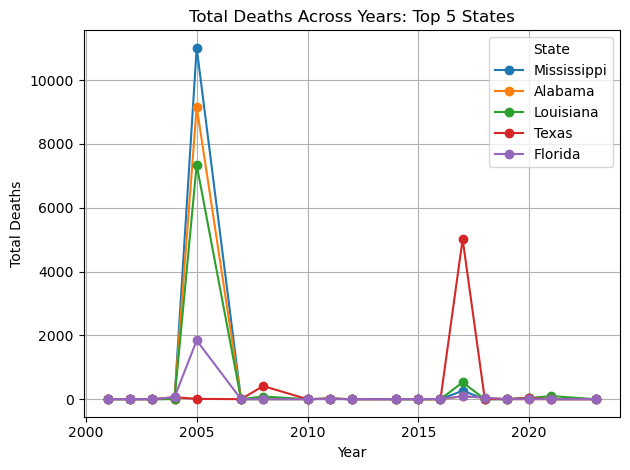

In [68]:
# Plot the data
plt.figure(figsize=(8, 6))
top_5_states_total_deaths_timeseries.T.plot(kind='line', marker='o')

plt.title('Total Deaths Across Years: Top 5 States')
plt.xlabel('Year')
plt.ylabel('Total Deaths')
plt.legend(title='State')
plt.grid(True)
plt.tight_layout()
plt.show()